# Iris data set: inference with NN / SVI + NUTS solution

In [2]:
import pyro
import numpy
import torch
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import model_selection
import pyro.distributions as pdist
import torch.distributions as tdist
import torch.nn as tnn
import pyro.nn as pnn
import arviz

/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set some parameters for inference and make reproducible.



In [3]:
seed_value = 42  # Replace with your desired seed value
torch.manual_seed(seed_value)
pyro.set_rng_seed(seed_value)
numpy.random.seed(seed_value)

# MAP or diagonal normal?
MAP=True
if MAP:
  MAXIT=2000 # SVI iterations
  REPORT=200 # Plot ELBO each time after this amount of SVI iterations
else:
  MAXIT=100000
  REPORT=1000

# Number of samples used in prediction
S=500

Function to evaluate the accuracy of our trained model.

In [4]:
def accuracy(pred, data):
  """
  Calculate accuracy of predicted labels (integers).

  pred: predictions, tensor[sample_index, chain_index, data_index, logits]
  data: actual data (digit), tensor[data_index]

  Prediction is taken as most common predicted value.
  Returns accuracy (#correct/#total).
  """
  n=data.shape[0]
  correct=0
  total=0
  for i in range(0, n):
      # Get most common prediction value from logits
      pred_i=int(torch.argmax(torch.sum(pred[:,0,i,:],0)))
      # Compare prediction with data
      if int(data[i])==int(pred_i):
          correct+=1.0
      total+=1.0
  # Return fractional accuracy
  return correct/total

Load the [iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set) set from [scikit-learn](https://sklearn.org/).

In [5]:
# Iris data set
Dx=4 # Input vector dim
Dy=3 # Number of labels

iris=sklearn.datasets.load_iris()
x_all=torch.tensor(iris.data, dtype=torch.float) # Input vector (4D)
y_all=torch.tensor(iris.target, dtype=torch.int) # Label(3 classes)

# Make training and test set
x, x_test, y, y_test = sklearn.model_selection.train_test_split(
    x_all, y_all, test_size=0.33, random_state=42)

print("Data set / test set sizes: %i, %i." % (x.shape[0], x_test.shape[0]))

Data set / test set sizes: 100, 50.


The probabilistic model, implemented as a callable class. We could also simply use a function.


In [6]:
class Model:
    def __init__(self, x_dim=4, y_dim=3, h_dim=5):
        self.x_dim=x_dim
        self.y_dim=y_dim
        self.h_dim=h_dim

    def __call__(self, x, y=None):
        """
        We need None for predictive
        """
        x_dim=self.x_dim
        y_dim=self.y_dim
        h_dim=self.h_dim
        # Number of observations
        n=x.shape[0]
        # standard deviation of Normals
        sd=1 # EXERCISE: 100->1
        # Layer 1
        w1=pyro.sample("w1", pdist.Normal(0, sd).expand([x_dim, h_dim]).to_event(2))
        b1=pyro.sample("b1", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 2 # EXERCISE: added layer
        w2=pyro.sample("w2", pdist.Normal(0, sd).expand([h_dim, h_dim]).to_event(2))
        b2=pyro.sample("b2", pdist.Normal(0, sd).expand([h_dim]).to_event(1))
        # Layer 3
        w3=pyro.sample("w3", pdist.Normal(0, sd).expand([h_dim, y_dim]).to_event(2))
        b3=pyro.sample("b3", pdist.Normal(0, sd).expand([y_dim]).to_event(1))
        # NN
        h1=torch.tanh((x @ w1) + b1)
        h2=torch.tanh((h1 @ w2) + b2) # EXERCISE: added layer
        logits=(h2 @ w3 + b3)
        # Save deterministc variable (logits) in trace
        pyro.deterministic("logits", logits)
        # Categorical likelihood
        with pyro.plate("labels", n):
            obs=pyro.sample("obs", pdist.Categorical(logits=logits), obs=y)

Make the Model and the Guide objects, and optimize the ELBO.  

In [11]:
# Instantiate the Model object
model=Model()

if MAP:
    # MAP estimate of model parameter (here SVI boild down to simple gradient descent)
    guide=pyro.infer.autoguide.AutoDelta(model)
else:
    # Variational estimate of model parameters using diagonal normal (SVI)
    guide=pyro.infer.autoguide.AutoDiagonalNormal(model)


def SVI(model, guide, x, y, x_test, y_test, plot=True):
    """
    model: model function
    guide: guide function
    x: input data
    y: output data
    plot: plot ELBO if True

    Returns: dict of loss, parameters and samples
    """

    store_dict={}

    # Optimizer
    adam=pyro.optim.Adam({"lr": 0.01})
    # SVI
    svi=pyro.infer.SVI(model, guide, adam, loss=pyro.infer.Trace_ELBO())

    # Clear any previously used parameters
    pyro.clear_param_store()

    # Optimize the ELBO
    elbo=[]
    for j in range(0, MAXIT):
        loss=svi.step(x, y)
        elbo.append(loss)
        if j%REPORT==0:
            print("[Iteration %04d] loss: %.4f" % (j, loss))

    # Predictive posterior i.e sample from posterior predictive, uses guide
    posterior_predictive=pyro.infer.Predictive(model, guide=guide, num_samples=S)
    posterior_samples=posterior_predictive(x_test)

    logits=posterior_samples["logits"]
    acc=accuracy(logits, y_test)
    print("Accuracy: %.3f" % acc)

    if plot:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        ax.plot(elbo)
        ax.set_title("SVI ELBO by iteration")
        ax.set_xlabel("Iteration")
        ax.set_ylabel("ELBO")

    # Store ELBO and parameters
    store_dict["elbo"]=elbo
    store_dict["samples"]=posterior_samples
    store_dict["accuracy"]=acc
    store_dict["parameters"]=pyro.get_param_store()

    return store_dict



def NUTS(model, x, y, x_test, y_test, plot=True):
    store_dict = {}

    nuts_kernel = pyro.infer.NUTS(model)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=1000, warmup_steps=100)
    mcmc.run(x, y)
    mcmc.summary()
    
    posterior_samples = mcmc.get_samples()
    
    # Posterior predictive samples
    S = 10
    posterior_predictive = pyro.infer.Predictive(model, posterior_samples, num_samples=S)
    posterior_predictive_samples = posterior_predictive(x_test)

    # Prior predictive samples
    prior_pred = pyro.infer.Predictive(model, num_samples=S)
    prior_samples = prior_pred(x_test)

    # Convert to arviz InferenceData
    az_data = arviz.from_pyro(mcmc,
        prior=prior_samples,                       # prior samples
        posterior_predictive=posterior_predictive_samples # posterior predictive samples
    )

    print("a", az_data)
    print("az", az_data.posterior)

    if plot:
        # Make sure these variables exist in posterior_samples
        arviz.plot_trace(az_data, var_names=["w1", "b1", "w2", "b2", "w3", "b3"])
        plt.show()

    store_dict["samples"] = posterior_samples
    store_dict["parameters"] = pyro.get_param_store()
    store_dict["az_data"] = az_data

    return store_dict


[Iteration 0000] loss: 181.7571
[Iteration 0200] loss: 88.1243
[Iteration 0400] loss: 87.4102
[Iteration 0600] loss: 87.3368
[Iteration 0800] loss: 87.3198
[Iteration 1000] loss: 87.3175
[Iteration 1200] loss: 87.3174
[Iteration 1400] loss: 87.4077
[Iteration 1600] loss: 87.3162
[Iteration 1800] loss: 87.3159
Accuracy: 0.980


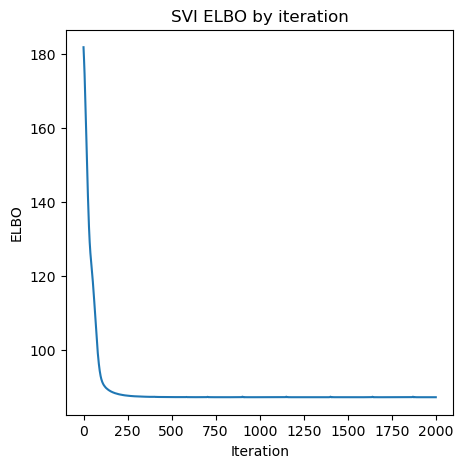

In [12]:
# SVI
store_dict=SVI(model, guide, x, y, x_test, y_test)


Sample: 100%|██████████| 1100/1100 [04:42,  3.89it/s, step size=1.37e-02, acc. prob=0.831]
/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/pyro/infer/predictive.py:206: UserWarning: Sample's leading dimension size 1000 is different from the provided 10 num_samples argument. Defaulting to 1000.
  warnings.warn(



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     b1[0]      0.08      1.05      0.05     -1.42      2.09    405.63      1.00
     b1[1]     -0.08      1.04     -0.07     -1.85      1.51    162.56      1.00
     b1[2]      0.02      1.05     -0.02     -1.57      1.83    157.42      1.00
     b1[3]      0.18      1.11      0.24     -1.56      2.04    123.59      1.03
     b1[4]      0.07      1.06      0.09     -1.64      1.79    220.33      1.03
     b2[0]     -0.05      0.93     -0.06     -1.56      1.48    590.65      1.00
     b2[1]     -0.02      0.89     -0.02     -1.52      1.47   1000.91      1.00
     b2[2]      0.01      0.90      0.05     -1.41      1.44    586.44      1.00
     b2[3]      0.02      0.94      0.01     -1.45      1.51    780.08      1.00
     b2[4]      0.00      0.96      0.02     -1.44      1.73    414.82      1.00
     b3[0]      0.07      0.91      0.09     -1.29      1.65    766.89      1.00
     b3[1]     -0.17      0

/Users/marcusdreisler/miniconda3/envs/PML/lib/python3.12/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


a Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
az <xarray.Dataset> Size: 300kB
Dimensions:   (chain: 1, draw: 1000, b1_dim_0: 5, b2_dim_0: 5, b3_dim_0: 3,
               w1_dim_0: 4, w1_dim_1: 5, w2_dim_0: 5, w2_dim_1: 5, w3_dim_0: 5,
               w3_dim_1: 3)
Coordinates:
  * chain     (chain) int64 8B 0
  * draw      (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * b1_dim_0  (b1_dim_0) int64 40B 0 1 2 3 4
  * b2_dim_0  (b2_dim_0) int64 40B 0 1 2 3 4
  * b3_dim_0  (b3_dim_0) int64 24B 0 1 2
  * w1_dim_0  (w1_dim_0) int64 32B 0 1 2 3
  * w1_dim_1  (w1_dim_1) int64 40B 0 1 2 3 4
  * w2_dim_0  (w2_dim_0) int64 40B 0 1 2 3 4
  * w2_dim_1  (w2_dim_1) int64 40B 0 1 2 3 4
  * w3_dim_0  (w3_dim_0) int64 40B 0 1 2 3 4
  * w3_dim_1  (w3_dim_1) int64 24B 0 1 2
Data variables:
    b1        (chain, draw, b1_dim_0) float32 20kB 0.7962 -1.947 ... 0.02541
    b2        (chain, draw, b2_dim_0) floa

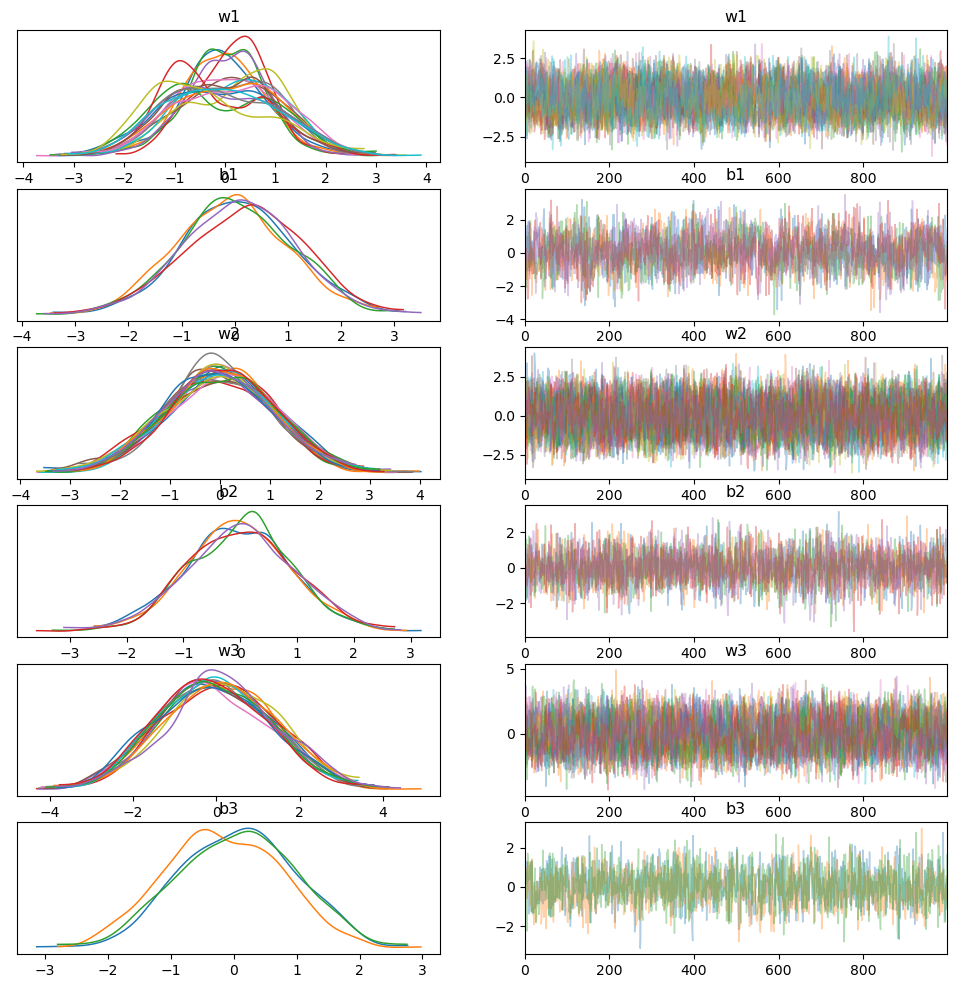

In [13]:
# NUTS
store_dict=NUTS(model, x, y, x_test, y_test)


Print the estimated parameters.

Get the [posterior predictive distribution](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) by sampling the model's parameters from the Guide object and applying the model to the test set.

Evaluate the accuracy of the model on the test set.
